Here is an example of loading up the baseline simualtion and returning information about the visits that overlap a single point in the sky.

Installation instructions for rubin_sim can be found in the README at: https://github.com/lsst/rubin_sim

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_sim.utils as rsUtils
from rubin_sim.data import get_baseline

In [2]:
# Grab the current baseline file. Should have been downloaded with rubin_sim. 
# Can grab lots of different sims from: http://astro-lsst-01.astro.washington.edu:8081/
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
conn = maf.db.OpsimDatabase(baseline_file)
outDir = 'temp'
resultsDb = maf.db.ResultsDb(outDir=outDir)

In [3]:
bundleList = []
# The point on the sky we would like to get visits for
ra = [0.]
dec = [-20]


# Say we just want to pass data through, not compute anything. Documentation on the columns coming soon.
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth'])
# Select all the visits
sql = ''
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
bundleList.append(maf.MetricBundle(metric, slicer, sql, runName=name))

In [4]:
bd = maf.metricBundles.makeBundlesDictFromList(bundleList)
bg = maf.metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()


Querying database SummaryAllProps with no constraint for columns ['fiveSigmaDepth', 'observationStartMJD', 'filter', 'fieldRA', 'rotSkyPos', 'fieldDec'].
Found 2045493 visits
Running:  ['baseline_nexp2_v1_7_10yrs_Pass_filter_observationStartMJD_fiveSigmaDepth_USER']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [5]:
# Our bundleList now has values. The trailing [0] is to get the first result. If we specified more
# ra,dec point, those results would be in the later indices.
bundleList[0].metricValues[0]

array([(22.8701956 , 60546.347425  , 'z', 3.58867842e+02, 300.47295981, -20.87119127),
       (23.21616806, 62747.15832206, 'u', 3.59018922e+02, 100.56224993, -21.2938007 ),
       (23.31237857, 61709.13837369, 'u', 3.58654368e+02, 304.0218046 , -20.89071499),
       (22.09925943, 60546.36385683, 'y', 3.58867842e+02, 302.43251009, -20.87119127),
       (23.07073822, 62338.31220137, 'z', 3.58418382e+02, 124.16614098, -20.88367014),
       (24.3010774 , 63418.43951074, 'r', 3.58971481e+02, 190.46954203, -20.92295587),
       (22.83026647, 62732.36429688, 'z', 3.58529338e+02, 317.48260288, -20.93819069),
       (22.7592126 , 63199.09958015, 'z', 3.58682554e+02, 192.1818866 , -20.83308581),
       (21.90215185, 61551.41030986, 'y', 3.58349382e+02, 169.28164396, -21.01431182),
       (24.02701227, 61330.07940052, 'r', 3.58737469e+02, 191.1572113 , -21.20443273),
       (21.79613264, 61248.2855901 , 'y', 3.58541018e+02, 121.34446632, -20.95326583),
       (23.97728841, 61678.32345247, 'g', 3

Text(0.5, 1.0, 'baseline_nexp2_v1.7_10yrs\nObservations at ra=0.000, dec=-20.000')

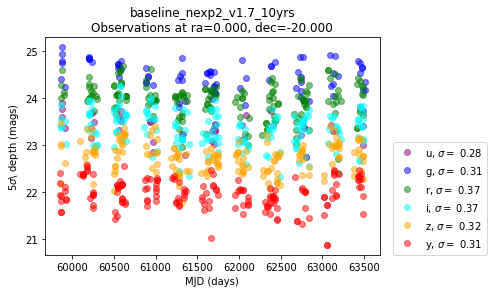

In [6]:
# As a bit of foreshadowing for how the rest of MAF works, we'll call the visits overlapping a
# single point in the sky "dataSlice". 
dataSlice = bundleList[0].metricValues[0]

# Let's plot up what the 5-sigma depth looks like
plt.figure()
# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}
for fn in f2c:
    in_filt = np.where(dataSlice['filter'] == fn)[0]
    plt.plot(dataSlice['observationStartMJD'][in_filt],
             dataSlice['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn],
             label=fn+r', $\sigma=$ %.2f' % (np.std(dataSlice['fiveSigmaDepth'][in_filt])),
             alpha=0.5)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$\ depth (mags)')
plt.legend(loc=(1.04,0))
plt.title('%s\nObservations at ra=%.3f, dec=%.3f' % (name, ra[0],dec[0]))